# Machine Learning Pipeline applied to recommender system using [MovieLens](https://movielens.org)

In [56]:
import numpy as np
import pandas as pd
import os
import re
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity


# Data Acquisition

In [57]:
file_path = os.path.join("..","data", "movies.csv")
movies = pd.read_csv(file_path)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [58]:
file_path = os.path.join("..","data", "ratings.csv")
ratings = pd.read_csv(file_path)
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
#Gives information about the variables
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [59]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


# Data exploration

In [6]:
# TODO: For each of the below tasks create a new code cell and research how to do it.
# TODO: Display statistics of each variable (describe)
# TODO: Display total number of nulls per variable

In [7]:
# Consider this instead
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [60]:
ratings_describe = ratings.describe()
print(ratings_describe)

              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09


In [9]:
#Checking for null values
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [61]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [11]:
#Make a copy of the 'movies' dataframe
updated_movies_df = movies.copy()

In [12]:
#Duplicated movies except the movie War of the Worlds
duplicates = updated_movies_df[updated_movies_df.duplicated(subset=['title'], keep=False)]
print(duplicates)

      movieId                                   title  \
650       838                             Emma (1996)   
2141     2851                         Saturn 3 (1980)   
4169     6003  Confessions of a Dangerous Mind (2002)   
5601    26958                             Emma (1996)   
5854    32600                             Eros (2004)   
5931    34048                War of the Worlds (2005)   
6932    64997                War of the Worlds (2005)   
9106   144606  Confessions of a Dangerous Mind (2002)   
9135   147002                             Eros (2004)   
9468   168358                         Saturn 3 (1980)   

                                   genres  
650                  Comedy|Drama|Romance  
2141            Adventure|Sci-Fi|Thriller  
4169          Comedy|Crime|Drama|Thriller  
5601                              Romance  
5854                                Drama  
5931     Action|Adventure|Sci-Fi|Thriller  
6932                        Action|Sci-Fi  
9106  Comedy|Crime|D

In [13]:
# Removes all duplicates of the movies and leaves the first duplicate
movies_no_duplicates = updated_movies_df.drop_duplicates(subset=['title'], keep='first')

In [14]:
# Keep only the duplicates for "War of the Worlds"
war_of_the_worlds = updated_movies_df[updated_movies_df['title'] == 'War of the Worlds (2005)']

In [15]:
# Concatenate the two dataframes to get the final result
final_movies = pd.concat([movies_no_duplicates, war_of_the_worlds.drop_duplicates(subset=['title'], keep='last')])
final_movies[final_movies['title'] == 'War of the Worlds (2005)']

,movieId,title,genres
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi


In [16]:
# Check if the movie War of the Worlds (2005) is kept and Emma (1996) has only one copy
print(final_movies[final_movies['title'] == 'War of the Worlds (2005)'])
print(final_movies[final_movies['title'] == 'Emma (1996)'])

      movieId                     title                            genres
5931    34048  War of the Worlds (2005)  Action|Adventure|Sci-Fi|Thriller
6932    64997  War of the Worlds (2005)                     Action|Sci-Fi
     movieId        title                genres
650      838  Emma (1996)  Comedy|Drama|Romance


In [17]:
# Extract the release year from the title using string manipulation
release_years = []
for title in updated_movies_df['title']:
    year_str = title[-5:-1]  # Extract the last 4 characters of the title
    if year_str.isdigit():
        release_year = int(year_str)
    else:
        release_year = None
    release_years.append(release_year)

# Replace NaN values with None
release_years = [year if pd.notnull(year) else None for year in release_years]

# Add the release year as a new column to the movies DataFrame
updated_movies_df['release year'] = release_years

# Convert the release year column to integer type
updated_movies_df['release year'] = updated_movies_df['release year'].astype('Int64')

# Print the first few rows of the movies DataFrame
print(updated_movies_df.head())


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  release year  
0  Adventure|Animation|Children|Comedy|Fantasy          1995  
1                   Adventure|Children|Fantasy          1995  
2                               Comedy|Romance          1995  
3                         Comedy|Drama|Romance          1995  
4                                       Comedy          1995  


In [18]:
#Now we want to remove the release year from the title column 

# Remove the release year from the title column using string manipulation
updated_movies_df['title'] = updated_movies_df['title'].str.replace(r'\s\(\d{4}\)', '', regex=True) #We used Regex

In [19]:
#Print the null values of the release year of each movie
# Filter the rows where the 'year' column is null
null_years = updated_movies_df[updated_movies_df['release year'].isnull()]

# Print the null years
null_years['title'].head(35)

5609            From Dusk Till Dawn 2: Texas Blood Money 
6059                                            Babylon 5
6706                    Justice League: The New Frontier 
6718                               Assembly (Ji jie hao) 
7878                                          96 Minutes 
7896                                   Superman/Doomsday 
7910               Pocahontas II: Journey to a New World 
7978                                       Runaway Brain 
8148                                Justice League: Doom 
8228                        3 dev adam (Three Giant Men) 
8302                    Guilty of Romance (Koi no tsumi) 
8565                           Dead Snow 2: Red vs. Dead 
9031                                     Ready Player One
9091                                           Hyena Road
9138    The Adventures of Sherlock Holmes and Doctor W...
9179                                    Nocturnal Animals
9259                                             Paterson
9367          

In [20]:
# # Loop over the null_years DataFrame and prompt the user to enter a year for each movie
# #This has been commented due to a successful outcome therefgore no need to be repeated everytime
# for index, row in null_years.iterrows():
#      print(row['title'])
#      year = int(input('Enter the release year for this movie: '))
#      updated_movies_df.loc[index, 'release year'] = year

# # Manually input the missing release years in the copy
# updated_movies_df.to_csv(os.path.join("..","data", "updated_movies.csv"), index=False)

In [21]:
file_path = os.path.join("..","data", "updated_movies.csv")
updated_movies = pd.read_csv(file_path)
updated_movies.head()

,movieId,title,genres,release year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [22]:
# Print the count of missing release years in the updated DataFrame
print('Missing release years in updated DataFrame:', updated_movies_df['release year'].isnull().sum())
print(updated_movies[updated_movies['title'] == 'Babylon 5'])


Missing release years in updated DataFrame: 23
      movieId      title  genres  release year
6059    40697  Babylon 5  Sci-Fi          1993


In [23]:
#Merging final_movies with ratings
data = pd.merge(updated_movies, ratings, on='movieId')
data.head()

,movieId,title,genres,release year,userId,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1,4.0,964982703
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,5,4.0,847434962
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,7,4.5,1106635946
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,15,2.5,1510577970
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,17,4.5,1305696483


In [24]:
data['release year'].isnull().sum()

0

In [25]:
#Make the timestamp into a date so that we can compare the timestamp that a user rated when the movie got released before or after
df_release_review = pd.DataFrame(data[['release year', 'timestamp']])
df_release_review['review date'] = pd.to_datetime(df_release_review['timestamp'], unit = 's')
df_release_review.head()

,release year,timestamp,review date
0,1995,964982703,2000-07-30 18:45:03
1,1995,847434962,1996-11-08 06:36:02
2,1995,1106635946,2005-01-25 06:52:26
3,1995,1510577970,2017-11-13 12:59:30
4,1995,1305696483,2011-05-18 05:28:03


In [26]:
#Taking the years only of the review date
df_release_review['year'] = df_release_review['review date'].dt.strftime('%Y').str[:4].astype(int)

In [27]:
#Calculate the number of years from the movie release year to the review date and make it as a graph

# calculate the number of years between release year and review date
df_release_review['years_since_release'] = (df_release_review['year']) - (df_release_review['release year'])
df_release_review['years_since_release'].fillna(0, inplace=True)
df_release_review.drop(['timestamp','review date'], axis=1, inplace=True)
df_release_review

,release year,year,years_since_release
0,1995,2000,5
1,1995,1996,1
2,1995,2005,10
3,1995,2017,22
4,1995,2011,16
...,...,...,...
100831,2017,2018,1
100832,2017,2018,1
100833,2017,2018,1
100834,2018,2018,0


# Data Visualisation

In [28]:
# TODO: Display frequencies per variable (matplotlib histograms)
# TODO: Display boxplots per variable - We have to rethink this, since it might not be relevant. Only relevant for average rating
# TODO: Display the corrleation values and plot for each variable

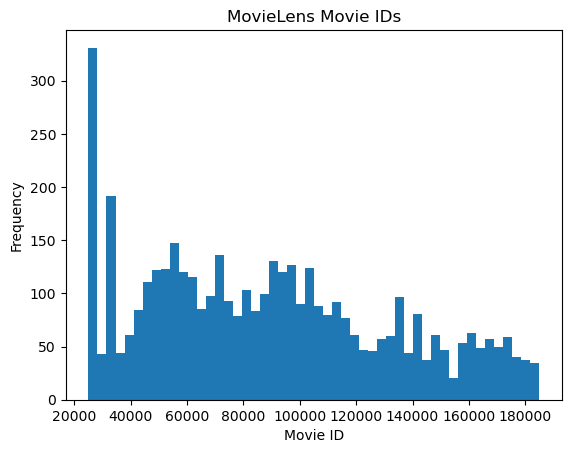

In [29]:
#Frequency for movieId We need to modify this as to make the longest bar more valid with the other bar
plt.hist(movies['movieId'], bins=50, range=(25000, 185000))
plt.title('MovieLens Movie IDs')
plt.xlabel('Movie ID')
plt.ylabel('Frequency')
plt.show()

In [30]:
# Create a list of all the genres
genres_list = movies['genres'].str.split('|')
genres = genres_list.explode()

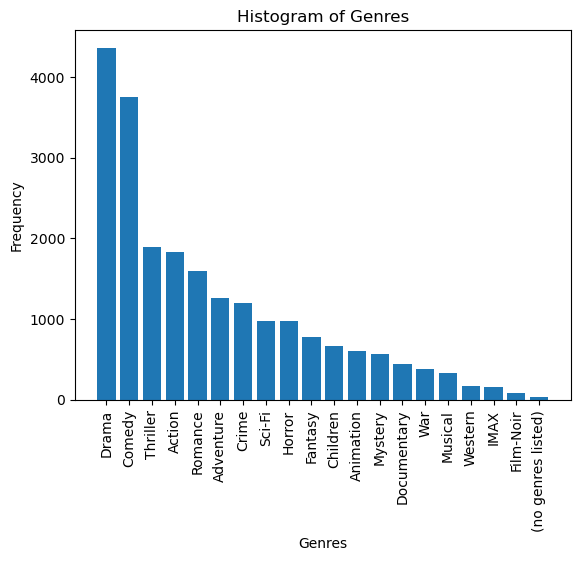

In [31]:
#Genres
genres_counts = genres.value_counts()
plt.bar(genres_counts.index, genres_counts.values)
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.title('Histogram of Genres')
plt.xticks(rotation=90)
plt.show()

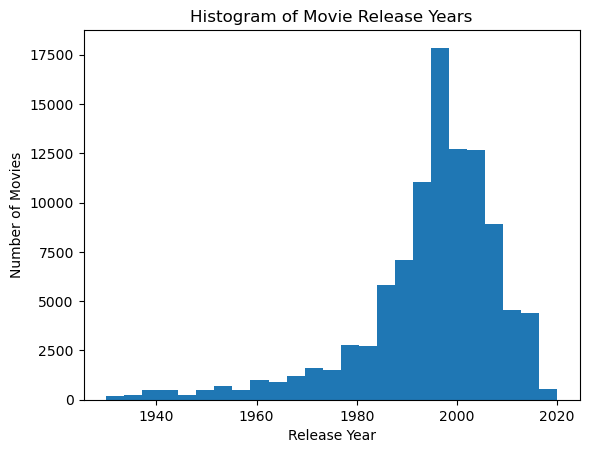

In [32]:
# Plot the histogram
plt.hist(data['release year'].dropna(), bins=25, range=(1930, 2020))
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.title('Histogram of Movie Release Years')
plt.show()

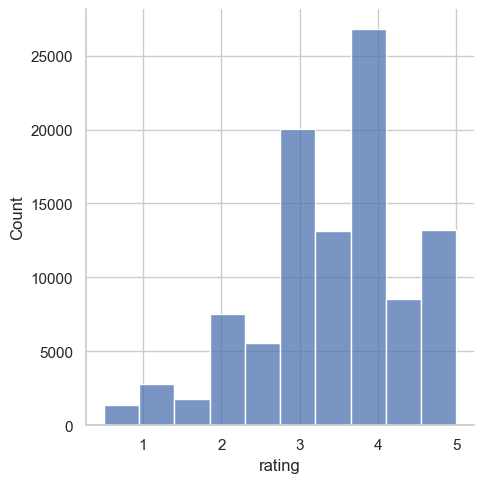

In [33]:
#Count of Ratings
sns.set_theme(style="whitegrid")
sns.displot(ratings, x="rating", bins=10, color="b")

In [34]:
#Grouping the ratings by movie ID
groupby_ratings = ratings.groupby('movieId')['rating']
#Calculating the mean rating for each movie
average_rating = groupby_ratings.mean()
average_rating.head()

movieId
1    3.920930
2    3.431818
3    3.259615
4    2.357143
5    3.071429
Name: rating, dtype: float64

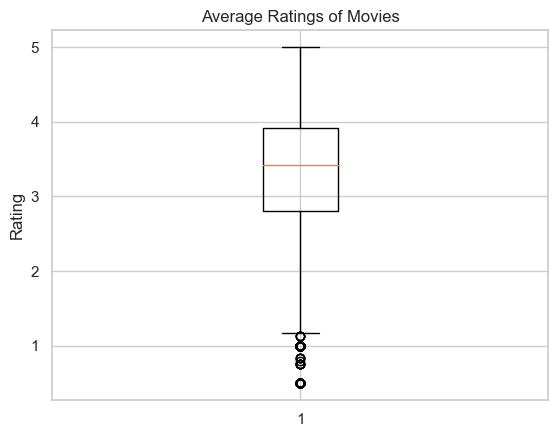

In [35]:
# Boxplot of the Average rating
plt.boxplot(average_rating)
plt.title('Average Ratings of Movies')
plt.ylabel('Rating')
plt.show()

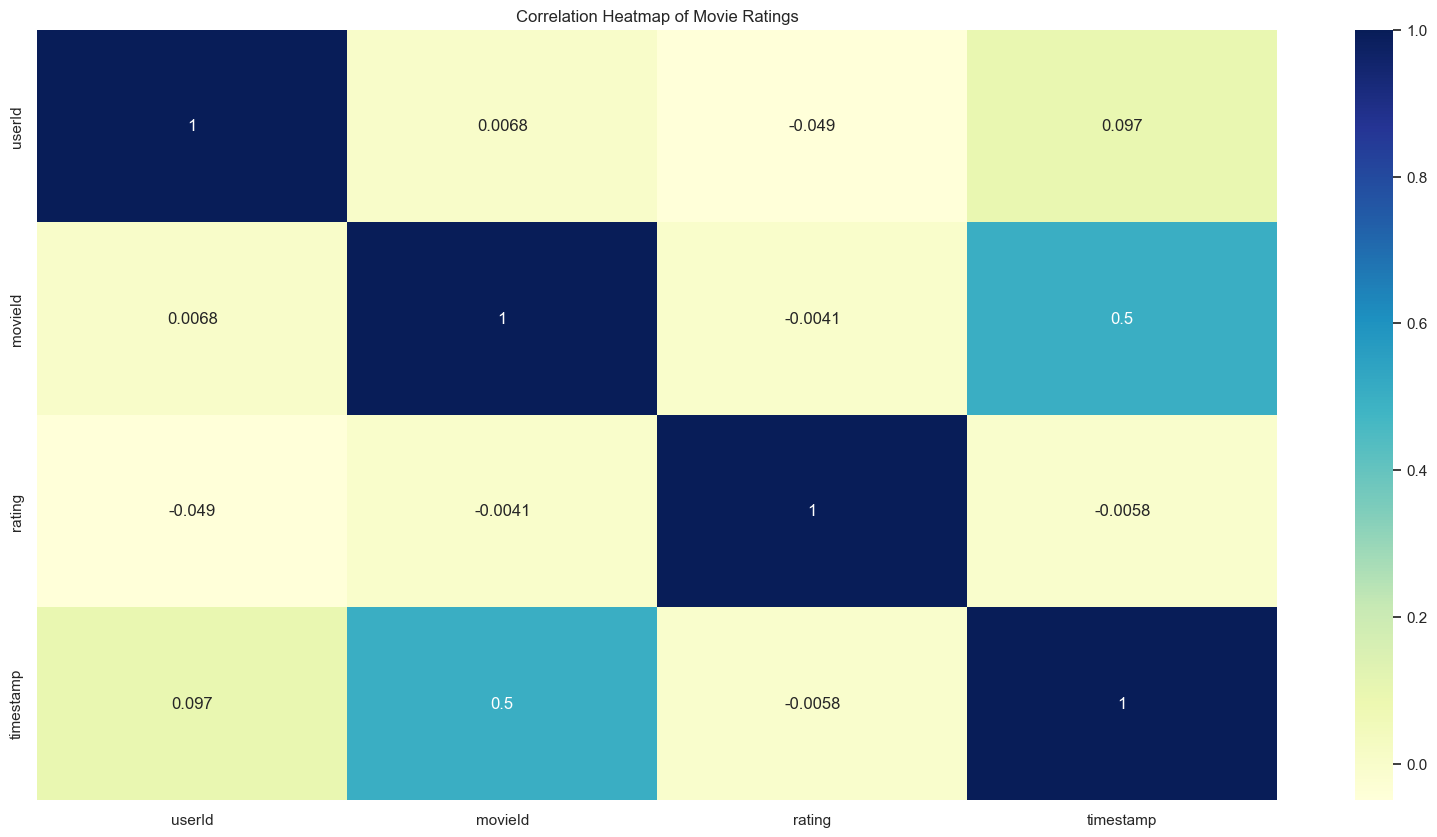

In [36]:
ratings_df = ratings['rating'].astype(int)
ratings['rating'] = ratings['rating']
corr = ratings.corr()

plt.figure(figsize=(20,10))
sns.heatmap(corr, cmap='YlGnBu', annot=True)
plt.title('Correlation Heatmap of Movie Ratings')
plt.show()

From the above we see that there is no real correlation with rating. THe only one is timestamp with movieID, only because reviews are mostly written after the movie is released, Thus as the movieId increases the timestamp increases.

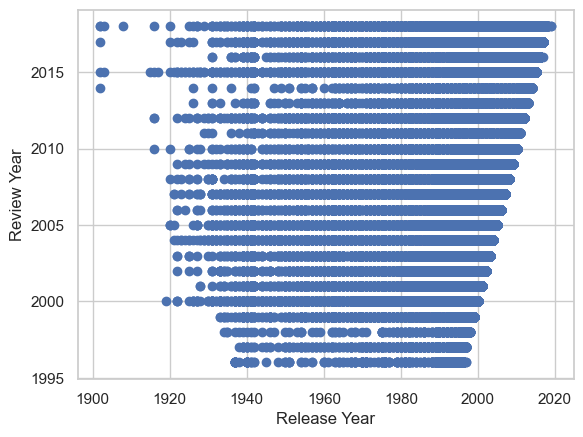

In [37]:
#Not sure about this need to ask sir
plt.scatter(df_release_review['release year'], df_release_review['year'])

# Set the labels for the axes
plt.xlabel('Release Year')
plt.ylabel('Review Year')

# Show the plot
plt.show()

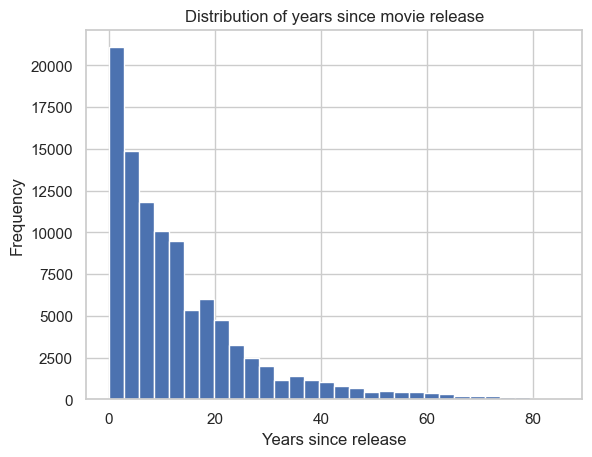

In [38]:
#Even this
# Plot the number of years since release
df_release_review['years_since_release'].plot.hist(bins=30, range = (0,85))
# Add labels and title to the plot
plt.xlabel('Years since release')
plt.ylabel('Frequency')
plt.title('Distribution of years since movie release')
plt.show()

# Data Cleaning

In [39]:
# TODO: remove any nulls
# TODO: Identify any problematic values (Title of movies, some movies have same name and release year, you need to research this situation and address accordingly)
# Arranged the duplicates in the above section as I merged the tables

In [40]:
#remove any nulls
data.dropna(inplace=True)
data.head()

,movieId,title,genres,release year,userId,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1,4.0,964982703
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,5,4.0,847434962
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,7,4.5,1106635946
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,15,2.5,1510577970
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,17,4.5,1305696483


In [41]:
# Create a new dataframe with one hot encoded genres
genres_df = updated_movies['genres'].str.get_dummies('|')

#Joining the new dataframe with original movies
movies_with_genres = updated_movies.join(genres_df)
# Drop the original genres column
movies_with_genres.drop('genres', axis=1, inplace=True)
movies_with_genres.head()

,movieId,title,release year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


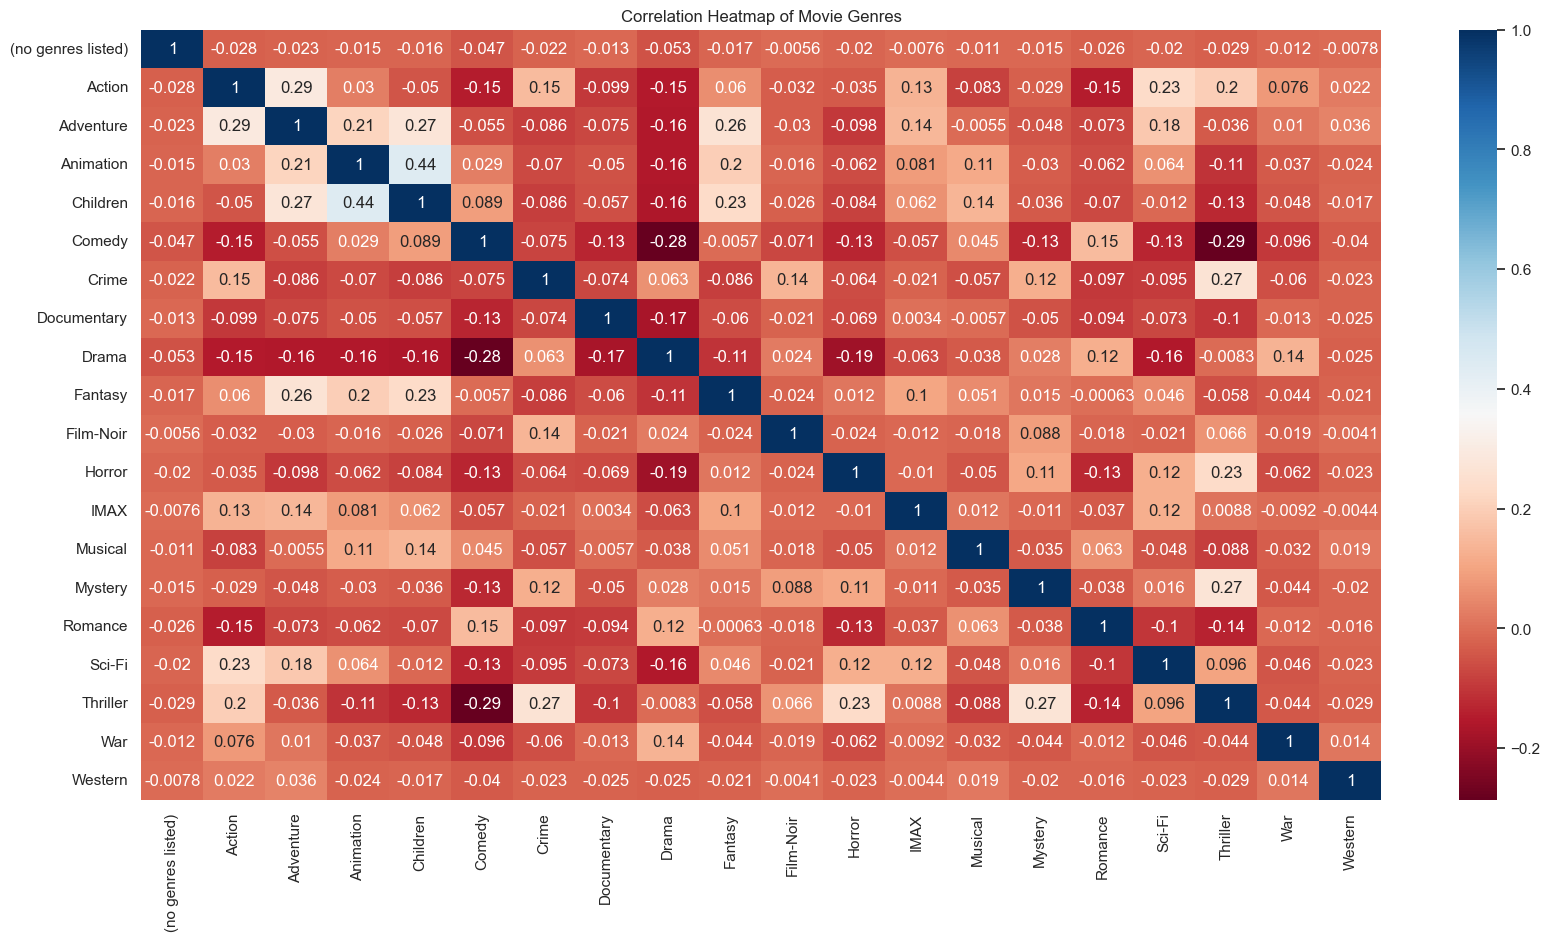

In [42]:
#Correlation of genres
corr = genres_df.corr()

plt.figure(figsize=(20,10))
sns.heatmap(corr, cmap='RdBu', annot=True)
plt.title('Correlation Heatmap of Movie Genres')
plt.show()

# Data Transformation

In [43]:
# TODO: At a later stage, not first iteration of this attempt, you might want to consider researching what PCA is.
# TODO: Consider manipulating some variables, such as the review date and calculate the number of years from the movie release year to the review date

# Data Splitting

In [44]:
# TODO: Split the data in different ratios (70:30, 80:20, 90:10) then run the experiments. This will allow you to answer a research question: What impact does the train to test split ratio have on the model.
# TODO: At a later point in time (even third year) you might want to consider different cross validation techniques (https://neptune.ai/blog/cross-validation-in-machine-learning-how-to-do-it-right)
train1, test1 = train_test_split(data, test_size=0.1, random_state=42)
train2, test2 = train_test_split(movies_with_genres, test_size=0.2, random_state=42)

# Model training

In [45]:
# TODO: create a model that recommends a movie given certain parameters. The most naive would be the general movie average rating, then you can add other factors, such as genre, release year, etc etc.
# TODO: at a later point in time, introduce a different algorithm.
# TODO: at an even later point in time, consider an advanced technique. https://medium.com/stanford-cs224w/graph-neural-network-based-movie-recommender-system-5876b9686df3

In [46]:
#This model uses the genre, what i can do is add the average ratings, so i can compute the metric results, also i can add the release year afterwards.
#What i can do is make use of this code but now i add the average rating that the user has rated, then i add another parameter the release year 

#Grouped by title with genre, which was used the one hot encoding of genre

# Group by title and calculate similarity using cosine similarity
grouped_movies = test2.groupby('title').mean()
similarity_matrix = cosine_similarity(grouped_movies.drop('movieId', axis=1))

# Define a function to recommend movies
def recommend_movies(movie_title, num_recommendations=10):
    # Find the index of the given movie
    movie_index = grouped_movies.index.get_loc(movie_title)

    # Get the similarity scores between the given movie and all other movies
    similarity_scores = similarity_matrix[movie_index]

    # Get the indices of the most similar movies
    similar_movie_indices = similarity_scores.argsort()[::-1][1:num_recommendations+1]

    # Return the titles of the recommended movies
    return grouped_movies.iloc[similar_movie_indices].index.tolist()

# Example usage:
recommended_movies = recommend_movies('Toy Story')
print('Top 10 recommended movies')
print(recommended_movies)

Top 10 recommended movies
['Shrek the Third', 'Tale of Despereaux, The', 'Home', 'Shrek', 'Ice Age', 'American Tail, An', 'Stuart Little 3: Call of the Wild', "Last Year's Snow Was Falling", 'Wow! A Talking Fish!', 'Pirates! Band of Misfits, The']


In [47]:
#Given the most naive recommendation system would be the general movie rating
#Calculating the mean rating of every movie.
#Sorting the movies in descending order in which the best rating would come first
groupby_rating_movies = test1.groupby('title')['rating']
average_rating_movies = groupby_rating_movies.mean()
sort_rating = average_rating_movies.sort_values(ascending=False)
top_movies = sort_rating.index.tolist()

# Recommend the top-rated movies to the user
print("Top 10 recommended Movies:")
for title in sort_rating.head(10).index:
 for ratings in sort_rating.head(1):
  print(f"{title}: {ratings}")

Top 10 recommended Movies:
Raise the Red Lantern (Da hong deng long gao gao gua): 5.0
Cabin in the Woods, The: 5.0
Kiss Me Deadly: 5.0
My Love: 5.0
Colonel Chabert, Le: 5.0
My Man Godfrey: 5.0
Blood Simple: 5.0
Killing, The: 5.0
Grave of the Fireflies (Hotaru no haka): 5.0
Eddie Murphy Raw: 5.0


# Model evaluation

In [48]:
# TODO: evaluate each model and generate metric results. Answer the research question: which model performs better in a specific situation?

In [49]:
# Predict ratings for the testing set
test1['predicted_rating'] = test1['movieId'].apply(lambda x: 5 if x in top_movies[:10] else 3)

# Compute the evaluation metrics
test_ratings = test1['rating']
predicted_ratings = test1['predicted_rating']
rmse = math.sqrt(mean_squared_error(test_ratings, predicted_ratings))
mae = mean_absolute_error(test_ratings, predicted_ratings)

# Display the evaluation metrics
print("Top 10 recommended movies using Average Rating model Metrics")
print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")
test1

Top 10 recommended movies using Average Rating model Metrics
RMSE: 1.16383
MAE: 0.94888


,movieId,title,genres,release year,userId,rating,timestamp,predicted_rating
67037,5418,"Bourne Identity, The",Action|Mystery|Thriller,2002,599,3.0,1498525228,3
42175,2329,American History X,Crime|Drama,1998,282,4.5,1378495649,3
93850,91529,"Dark Knight Rises, The",Action|Adventure|Crime|IMAX,2012,282,4.0,1514068391,3
6187,230,Dolores Claiborne,Drama|Thriller,1995,414,3.0,961517975,3
12229,440,Dave,Comedy|Romance,1993,136,5.0,832449786,3
...,...,...,...,...,...,...,...,...
52065,3158,"Emperor and the Assassin, The (Jing ke ci qin ...",Drama,1999,182,4.0,1094400787,3
92269,82459,True Grit,Western,2010,610,4.0,1479544338,3
18346,736,Twister,Action|Adventure|Romance|Thriller,1996,474,2.0,974667817,3
17425,648,Mission: Impossible,Action|Adventure|Mystery|Thriller,1996,96,3.0,964772610,3


# Post-Processing

This is an advanced step and does not necessarily need to be done in 2nd year, yet it is good that you know that it exists. You can, but are not obliged to do so, consider for 3rd year.

In [ ]:
# TODO: Assess the incorrect recommendations and investigate to answer the research question: Which recommendations were bad and why did they occur?